In [1]:
import pandas as pd

# Load dataset
url = "/kaggle/input/heart-disease-dataset-uci/HeartDiseaseTrain-Test.csv"
df = pd.read_csv(url)

# Check first rows
print(df.head())
print(df.info())


   age     sex chest_pain_type  resting_blood_pressure  cholestoral  \
0   52    Male  Typical angina                     125          212   
1   53    Male  Typical angina                     140          203   
2   70    Male  Typical angina                     145          174   
3   61    Male  Typical angina                     148          203   
4   62  Female  Typical angina                     138          294   

      fasting_blood_sugar               rest_ecg  Max_heart_rate  \
0    Lower than 120 mg/ml  ST-T wave abnormality             168   
1  Greater than 120 mg/ml                 Normal             155   
2    Lower than 120 mg/ml  ST-T wave abnormality             125   
3    Lower than 120 mg/ml  ST-T wave abnormality             161   
4  Greater than 120 mg/ml  ST-T wave abnormality             106   

  exercise_induced_angina  oldpeak        slope vessels_colored_by_flourosopy  \
0                      No      1.0  Downsloping                           Two   
1 

In [2]:
print(df.columns.tolist())

['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholestoral', 'fasting_blood_sugar', 'rest_ecg', 'Max_heart_rate', 'exercise_induced_angina', 'oldpeak', 'slope', 'vessels_colored_by_flourosopy', 'thalassemia', 'target']


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

url = "/kaggle/input/heart-disease-dataset-uci/HeartDiseaseTrain-Test.csv"
df = pd.read_csv(url)

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')


binary_mapping = {
    'sex': {'Male': 1, 'Female': 0},
    'fasting_blood_sugar': {'Lower than 120 mg/ml': 0, 'Greater than 120 mg/ml': 1},
    'exercise_induced_angina': {'No': 0, 'Yes': 1}
}

for col, mapping in binary_mapping.items():
    df[col] = df[col].map(mapping)


vessel_mapping = {
    'Zero': 0,
    'One': 1,
    'Two': 2,
    'Three': 3,
    'Four': 4  # if any
}
df['vessels_colored_by_flourosopy'] = df['vessels_colored_by_flourosopy'].map(vessel_mapping)

multi_class_cols = ['chest_pain_type', 'rest_ecg', 'slope', 'thalassemia']
df = pd.get_dummies(df, columns=multi_class_cols, drop_first=True)


num_cols = ['age', 'resting_blood_pressure', 'cholestoral', 'max_heart_rate', 'oldpeak', 'vessels_colored_by_flourosopy']
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


X = df.drop('target', axis=1).values
y = df['target'].values


num_samples, num_features = X.shape
size = int(np.ceil(np.sqrt(num_features)))  # square input
padded_X = np.zeros((num_samples, size*size))
padded_X[:, :num_features] = X
X_cnn = padded_X.reshape(num_samples, size, size, 1)


print("Features shape for CNN:", X_cnn.shape)
print("Features shape for fuzzy logic:", X.shape)
print("Target shape:", y.shape)


Features shape for CNN: (1025, 5, 5, 1)
Features shape for fuzzy logic: (1025, 19)
Target shape: (1025,)


In [4]:
!pip install tensorflow keras scikit-fuzzy shap matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 12.4 MB/s eta 0:00:0000:0100:01


In [5]:
!pip install tensorflow keras efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.6 MB/s eta 0:00:00


In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Concatenate, Conv2D
from tensorflow.keras.optimizers import Adam
import efficientnet.tfkeras as efn
import shap
import matplotlib.pyplot as plt

2025-08-13 15:55:27.769277: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755100528.145523      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755100528.252183      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
# Assume df is cleaned with all categorical columns one-hot encoded and numeric scaled

X = df.drop('target', axis=1).values
y = df['target'].values

# Pad and reshape for CNN
num_samples, num_features = X.shape
size = int(np.ceil(np.sqrt(num_features)))  # e.g., 5
padded_X = np.zeros((num_samples, size*size))
padded_X[:, :num_features] = X

# Convert to 3 channels and resize to 32x32
X_cnn = padded_X.reshape(num_samples, size, size, 1)
X_cnn = np.repeat(X_cnn, 3, axis=-1)
X_cnn_resized = tf.image.resize(X_cnn, (32,32)).numpy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_cnn_resized, y, test_size=0.2, random_state=42)

I0000 00:00:1755100555.732990      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755100555.733770      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121

# Model with DenseNet121 backbone
cnn_model = Sequential([
    InputLayer(input_shape=(224,224,3)),              # Resize pseudo-image features to 224x224
    DenseNet121(weights='imagenet', include_top=False),  
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer=Adam(0.0001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

cnn_model.summary()


Argument `input_shape` is deprecated. Use `shape` instead.


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,168,833 (27.35 MB)

 Trainable params: 7,085,185 (27.03 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [9]:
cnn_probs_train = cnn_model.predict(X_train).flatten()
cnn_probs_test = cnn_model.predict(X_test).flatten()

I0000 00:00:1755100566.131389      95 service.cc:148] XLA service 0x7aecf4001fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755100566.132835      95 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755100566.132858      95 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755100567.551491      95 cuda_dnn.cc:529] Loaded cuDNN version 90300


13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

I0000 00:00:1755100575.144656      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 520ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step 


In [10]:
import numpy as np

# Select key features from your dataset (example)
key_features = ['age', 'cholestoral', 'oldpeak']
X_tsk = df[key_features].values

# CNN output probabilities (already trained)
cnn_probs = cnn_model.predict(X_cnn_resized).flatten()  # shape: (num_samples,)

# Combine CNN probability with key features
X_fuzzy = np.hstack([X_tsk, cnn_probs.reshape(-1,1)])  # shape: (num_samples, 4)
y = df['target'].values

33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step


In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import Input, Model

class AdaptiveTSK(Layer):
    def __init__(self, n_rules=5, n_inputs=4, **kwargs):
        super(AdaptiveTSK, self).__init__(**kwargs)
        self.n_rules = n_rules
        self.n_inputs = n_inputs
        
        # Trainable weights for each rule: w0 + w1*x1 + ... + wn*xn
        self.w = self.add_weight(shape=(n_rules, n_inputs+1),
                                 initializer='random_normal',
                                 trainable=True)
    
    def call(self, inputs):
        # inputs: shape (batch_size, n_inputs)
        batch_size = tf.shape(inputs)[0]
        
        # Fuzzification (simple normalized membership: 0-1)
        # For demo, use inputs scaled 0-1
        memberships = tf.expand_dims(inputs, 1)  # shape (batch, 1, n_inputs)
        memberships = tf.tile(memberships, [1, self.n_rules, 1])  # (batch, n_rules, n_inputs)
        
        # Rule firing strength = product of memberships (simplified)
        firing_strength = tf.reduce_prod(memberships, axis=-1)  # (batch, n_rules)
        
        # Consequent output y_r = w0 + w1*x1 + ...
        x_with_bias = tf.concat([tf.ones((batch_size,1)), inputs], axis=1)  # (batch, n_inputs+1)
        x_with_bias = tf.expand_dims(x_with_bias, 1)  # (batch,1,n_inputs+1)
        x_with_bias = tf.tile(x_with_bias, [1, self.n_rules, 1])  # (batch, n_rules, n_inputs+1)
        
        y_r = tf.reduce_sum(self.w * x_with_bias, axis=-1)  # (batch, n_rules)
        
        # Weighted average (defuzzification)
        risk_score = tf.reduce_sum(firing_strength * y_r, axis=1) / (tf.reduce_sum(firing_strength, axis=1) + 1e-6)
        return tf.expand_dims(risk_score, axis=-1)


In [12]:
# Freeze CNN
cnn_model.trainable = False

# Inputs
input_features = Input(shape=(X_fuzzy.shape[1],))  # 4 features: age, chol, oldpeak, CNN_prob

# TSK layer
tsk_output = AdaptiveTSK(n_rules=5, n_inputs=X_fuzzy.shape[1])(input_features)

# Model
tsk_model = Model(inputs=input_features, outputs=tsk_output)
tsk_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
tsk_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ adaptive_tsk (AdaptiveTSK)      │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25 (100.00 B)

 Trainable params: 25 (100.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
# X_fuzzy: features + CNN probability
tsk_model.fit(X_fuzzy, y, epochs=50, batch_size=16, validation_split=0.1)


Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5079 - loss: 7.9317 - val_accuracy: 0.4563 - val_loss: 8.7632
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4979 - loss: 8.0921 - val_accuracy: 0.4563 - val_loss: 8.7632
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4892 - loss: 8.2335 - val_accuracy: 0.4563 - val_loss: 8.7632
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4797 - loss: 8.3855 - val_accuracy: 0.4563 - val_loss: 8.7632
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5282 - loss: 7.6049 - val_accuracy: 0.4563 - val_loss: 8.7632
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5136 - loss: 7.8405 - val_accuracy: 0.4563 - val_loss: 8.7632
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4959 - loss: 8.1251 - val_accuracy: 0.4563 - val_loss: 8.7632
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4872 - loss: 8.2652 - val_accuracy: 0.4563 - val_loss

In [14]:
risk_scores = tsk_model.predict(X_fuzzy).flatten()

# Severity mapping
severity = np.where(risk_scores <= 0.33, 'Mild',
             np.where(risk_scores <= 0.66, 'Moderate', 'Severe'))

# Example output
for i in range(5):
    print(f"Patient {i}: Risk Score={risk_scores[i]:.2f}, Severity={severity[i]}")


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Patient 0: Risk Score=-0.02, Severity=Mild
Patient 1: Risk Score=-0.02, Severity=Mild
Patient 2: Risk Score=-0.03, Severity=Mild
Patient 3: Risk Score=0.00, Severity=Mild
Patient 4: Risk Score=-0.03, Severity=Mild


In [15]:
import numpy as np

# Flatten pseudo-image inputs for KernelExplainer
X_background_flat = X_cnn_resized[:50].reshape(50, -1)
X_test_flat = X_cnn_resized[:10].reshape(10, -1)

# Wrapper function to reshape back to (32,32,3) before prediction
def cnn_predict_wrapper(X):
    X_reshaped = X.reshape(-1, 32, 32, 3)
    return cnn_model.predict(X_reshaped)

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step 


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
11704/11704 ━━━━━━━━━━━━━━━━━━━━ 109s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
11704/11704 ━━━━━━━━━━━━━━━━━━━━ 104s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
11704/11704 ━━━━━━━━━━━━━━━━━━━━ 106s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
11704/11704 ━━━━━━━━━━━━━━━━━━━━ 105s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
11704/11704 ━━━━━━━━━━━━━━━━━━━━ 106s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
11704/11704 ━━━━━━━━━━━━━━━━━━━━ 106s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
11704/11704 ━━━━━━━━━━━━━━━━━━━━ 106s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
11704/11704 ━━━━━━━━━━━━━━━━━━━━ 105s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
11704/11704 ━━━━━━━━━━━━━━━━━━━━ 105s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
11704/11704 ━━━━━━━━━━━━━━━━━━━━ 105s 9ms/step


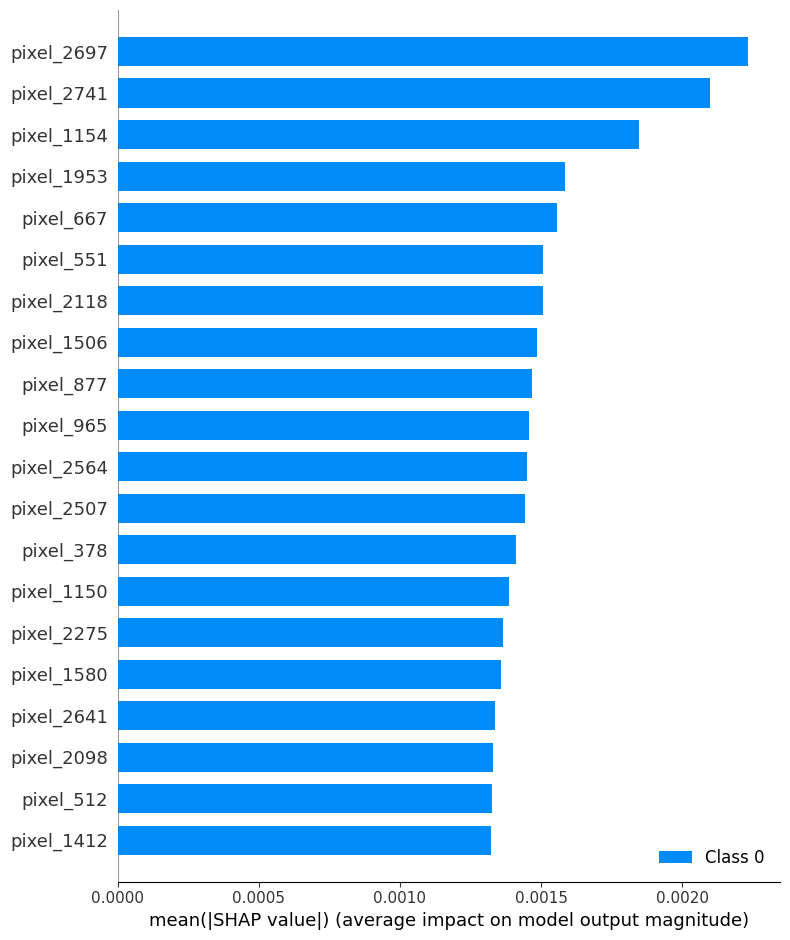

In [16]:
import shap

# KernelExplainer for CNN
explainer_cnn = shap.KernelExplainer(cnn_predict_wrapper, X_background_flat)
shap_values_cnn = explainer_cnn.shap_values(X_test_flat)

# Summary plot for CNN
shap.summary_plot(shap_values_cnn, X_test_flat, feature_names=[f"pixel_{i}" for i in range(X_test_flat.shape[1])])

In [17]:
cnn_probs = cnn_model.predict(X_cnn_resized).flatten()
key_features = df[['age', 'cholestoral', 'oldpeak']].values
X_fuzzy = np.hstack([key_features, cnn_probs.reshape(-1,1)])  # shape: (num_samples, 4)

# Train/test split for TSK if needed
X_fuzzy_test = X_fuzzy[:10]
X_fuzzy_background = X_fuzzy[:50]

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


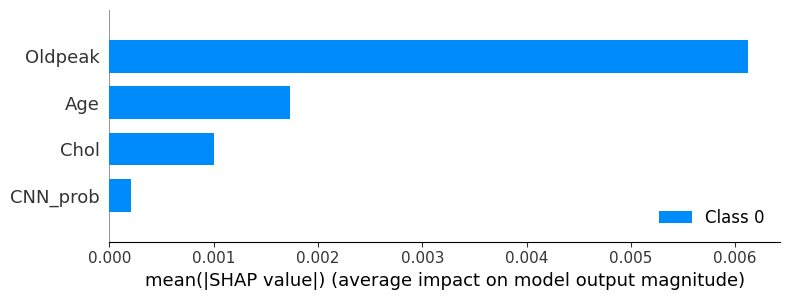

In [18]:
explainer_tsk = shap.KernelExplainer(tsk_model.predict, X_fuzzy_background)
shap_values_tsk = explainer_tsk.shap_values(X_fuzzy_test)

# Summary plot for TSK
feature_names = ['Age','Chol','Oldpeak','CNN_prob']
shap.summary_plot(shap_values_tsk, X_fuzzy_test, feature_names=feature_names)

In [19]:
risk_scores = tsk_model.predict(X_fuzzy_test).flatten()

# Map to severity
severity = np.where(risk_scores <= 0.33, 'Mild',
             np.where(risk_scores <= 0.66, 'Moderate', 'Severe'))

# Example display
for i in range(len(X_fuzzy_test)):
    print(f"Patient {i}: Risk Score={risk_scores[i]:.2f}, Severity={severity[i]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Patient 0: Risk Score=-0.02, Severity=Mild
Patient 1: Risk Score=-0.02, Severity=Mild
Patient 2: Risk Score=-0.03, Severity=Mild
Patient 3: Risk Score=0.00, Severity=Mild
Patient 4: Risk Score=-0.03, Severity=Mild
Patient 5: Risk Score=-0.03, Severity=Mild
Patient 6: Risk Score=-0.02, Severity=Mild
Patient 7: Risk Score=-0.03, Severity=Mild
Patient 8: Risk Score=-0.02, Severity=Mild
Patient 9: Risk Score=-0.02, Severity=Mild


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


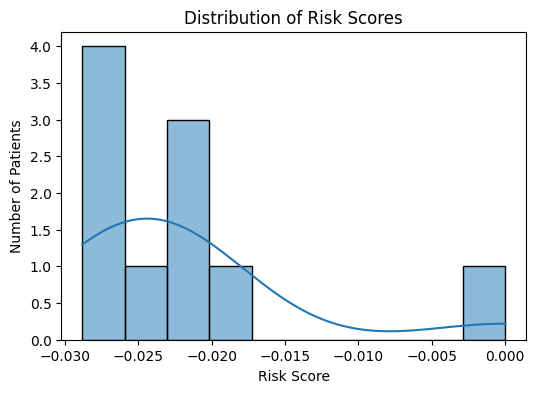

In [20]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.histplot(risk_scores, bins=10, kde=True)
plt.xlabel('Risk Score')
plt.ylabel('Number of Patients')
plt.title('Distribution of Risk Scores')
plt.show()


When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


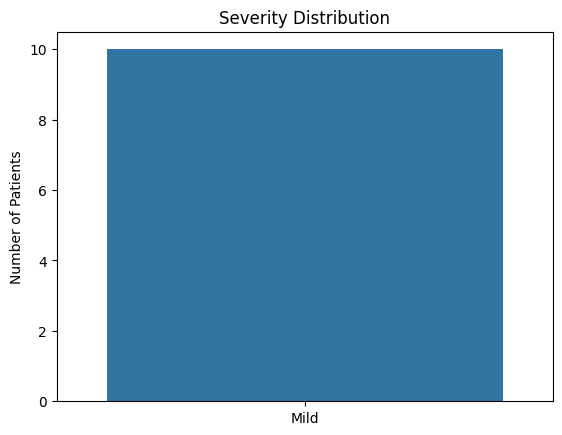

In [21]:
severity_counts = pd.Series(severity).value_counts()
sns.barplot(x=severity_counts.index, y=severity_counts.values)
plt.ylabel('Number of Patients')
plt.title('Severity Distribution')
plt.show()


In [22]:
# For CNN + TSK hybrid, use TSK final output
y_pred_prob = tsk_model.predict(X_fuzzy).flatten()  # continuous risk score (0-1)
y_true = y  

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


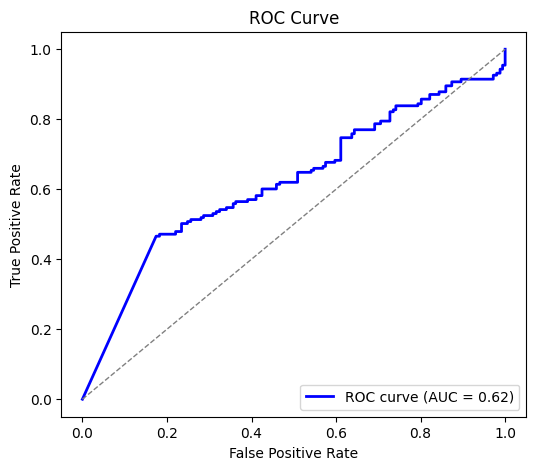

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

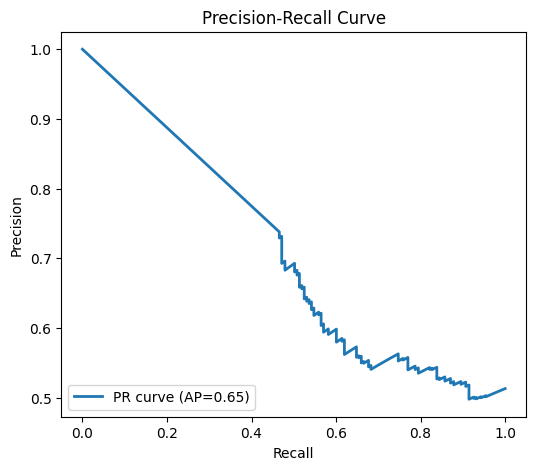

In [24]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
avg_precision = average_precision_score(y_true, y_pred_prob)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, lw=2, label=f'PR curve (AP={avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


Accuracy: 0.487
Precision: 0.000
Recall: 0.000
F1-score: 0.000


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


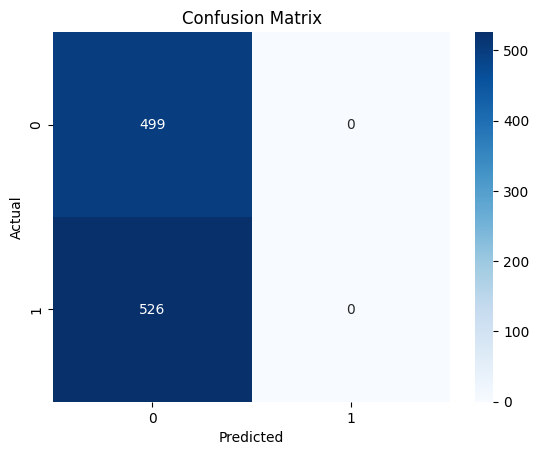

              precision    recall  f1-score   support

  No Disease       0.49      1.00      0.65       499
     Disease       0.00      0.00      0.00       526

    accuracy                           0.49      1025
   macro avg       0.24      0.50      0.33      1025
weighted avg       0.24      0.49      0.32      1025



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [25]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

# Convert risk scores to binary predictions using 0.5 threshold
y_pred = (y_pred_prob >= 0.5).astype(int)

# Accuracy, Precision, Recall, F1-score
accuracy = accuracy_score(y_true, y_pred)
precision_val = precision_score(y_true, y_pred)
recall_val = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision_val:.3f}")
print(f"Recall: {recall_val:.3f}")
print(f"F1-score: {f1:.3f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Detailed classification report
print(classification_report(y_true, y_pred, target_names=['No Disease','Disease']))
